In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Angsana New'
rcParams.update({'font.size': 22})
rcParams['axes.unicode_minus'] = False

In [3]:
# df_read = pd.read_csv('data/corrected_data.csv')
df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly-corrected.csv', parse_dates=["datetime"])
df_read_original = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly.csv', parse_dates=["datetime"])

In [4]:
df = df_read.copy()
print(df.dtypes)

index                int64
datetime    datetime64[ns]
ec                 float64
dtype: object


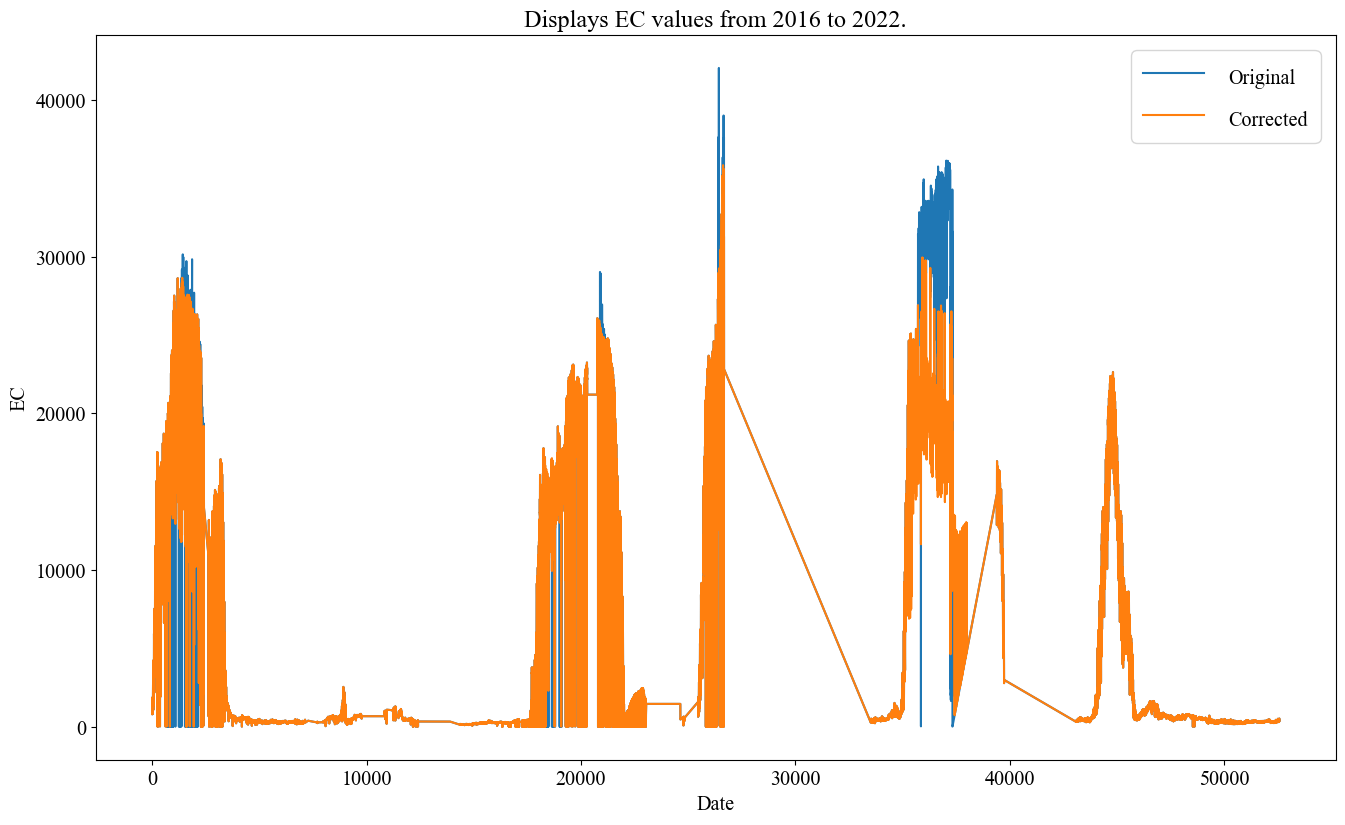

In [5]:
plt.figure(figsize=(16,32))
plt.subplot(3,1,1)
plt.title('Displays EC values from 2016 to 2022.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df_read_original['ec'], label='Original')
plt.plot(df['ec'], label='Corrected')
plt.legend()

# plt.subplot(3,1,2)
# plt.title('Displays Temp. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('°C')
# plt.plot(df['temperature'], label='OG temp.')
# plt.plot(df['temp_new_1'], label='temp_new_1')
# plt.plot(df['temp_new_2'], label='temp_new_2')
# plt.plot(df['temp_new_3'], label='temp_new_3')
# plt.plot(df['temp_new_4'], label='temp_new_4')
# plt.plot(df['temp_new_.5'], label='temp_new_.5')
# plt.legend()

# plt.subplot(3,1,3)
# plt.title('Displays pH. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('pH')
# plt.plot(df['pH'], label='OG pH')
# plt.plot(df['pH_new_1'], label='pH_new_1')
# plt.plot(df['pH_new_2'], label='pH_new_2')
# plt.plot(df['pH_new_3'], label='pH_new_3')
# plt.plot(df['pH_new_4'], label='pH_new_4')
# plt.plot(df['pH_new_.5'], label='pH_new_.5')
# plt.legend()

In [6]:
# =============================================================================
# กำหนดตัวแปรที่ต้องการใช้ train ตัว model
# =============================================================================

data = df.filter(['ec'])
dataset = data.values

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [8]:
# =============================================================================
# MinMaxScaler
# =============================================================================

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

# dataset_scaled = scaler.fit_transform(dataset)

In [9]:
n_future = 24
n_past = 48

In [10]:
# import math

# train_set_len = math.ceil(len(dataset) * 0.80)
# valid_set_len = math.ceil(len(dataset) * 0.10)

# first 3yrs
train_set_len = 26280

# last year
valid_set_len = 17544

In [11]:
train_set = dataset_scaled[0:train_set_len, :]

x_train = []
y_train = []

for i in range(n_past, len(train_set) - n_future + 1):
    x_train.append(train_set[i - n_past:i, 0:dataset.shape[1]])
    y_train.append(train_set[i:i + n_future, 0])

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [13]:
valid_set = dataset_scaled[train_set_len - n_past:train_set_len + valid_set_len, :]

x_valid = []
y_valid = []

for i in range(n_past, len(valid_set) - n_future + 1):
    x_valid.append(valid_set[i - n_past:i, 0:dataset.shape[1]])
    y_valid.append(valid_set[i:i + n_future, 0])

In [14]:
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
y_valid = np.reshape(y_valid, (y_valid.shape[0], y_valid.shape[1], 1))

In [15]:
test_set = dataset_scaled[(train_set_len + valid_set_len) - n_past:, :]
test_real = dataset[(train_set_len + valid_set_len) - n_past:, :]

x_test = []
y_test = []

for i in range(n_past, len(test_set) - n_future + 1):
    x_test.append(test_set[i - n_past:i, 0:dataset.shape[1]])
    y_test.append(test_real[i:i + n_future, 0])

In [16]:
x_test, y_test = np.array(x_test), np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

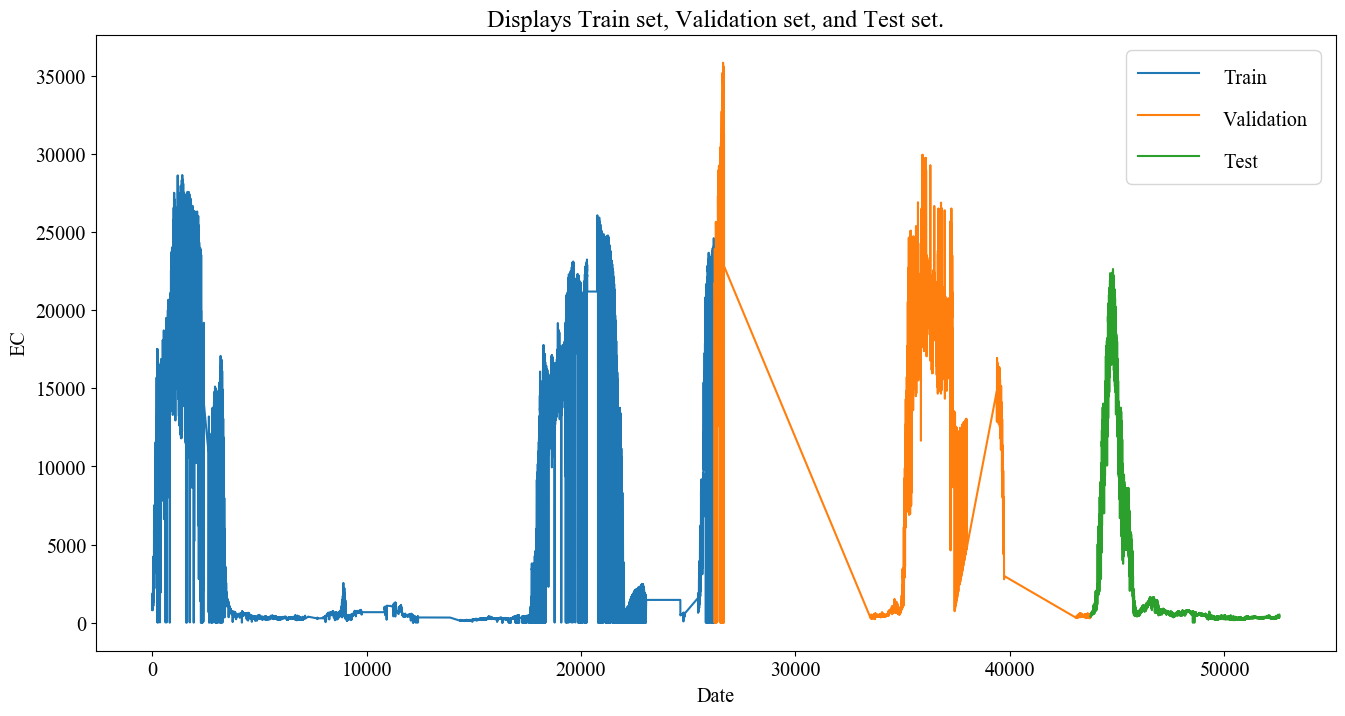

In [17]:
plt.figure(figsize=(16,8))
plt.title('Displays Train set, Validation set, and Test set.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df[0:train_set_len]["ec"], label='Train')
plt.plot(df[train_set_len - n_past:train_set_len + valid_set_len]["ec"], label='Validation')
plt.plot(df[(train_set_len + valid_set_len) - n_past:]["ec"], label='Test')
plt.legend()
plt.show()

In [18]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
# from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
# from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
# =============================================================================
# Bidirectional LSTM
# =============================================================================

model = Sequential()
model.add(Bidirectional(LSTM(192, return_sequences=True), input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(Bidirectional(LSTM(96, return_sequences=True)))
model.add(Bidirectional(LSTM(192, return_sequences=False)))
model.add(Dense(n_future))

# model.add(Dense(16))
# model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 384)          297984    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 384)              886272    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24)                9240      
                                                                 
Total params: 1,193,496
Trainable params: 1,193,496
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 384) 

In [21]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [22]:
checkpoint_filepath = 'checkpoint/01-bilstm-24-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [23]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1093/1093 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043
Epoch 1: val_loss improved from inf to 0.00181, saving model to checkpoint\01-bilstm-24-3-2-1.h5
1093/1093 [==============================] - 513s 465ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/128
1093/1093 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031
Epoch 2: val_loss did not improve from 0.00181
1093/1093 [==============================] - 644s 589ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/128
1093/1093 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029
Epoch 3: val_loss improved from 0.00181 to 0.00166, saving model to checkpoint\01-bilstm-24-3-2-1.h5
1093/1093 [==============================] - 661s 605ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/128
1093/1093 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.002

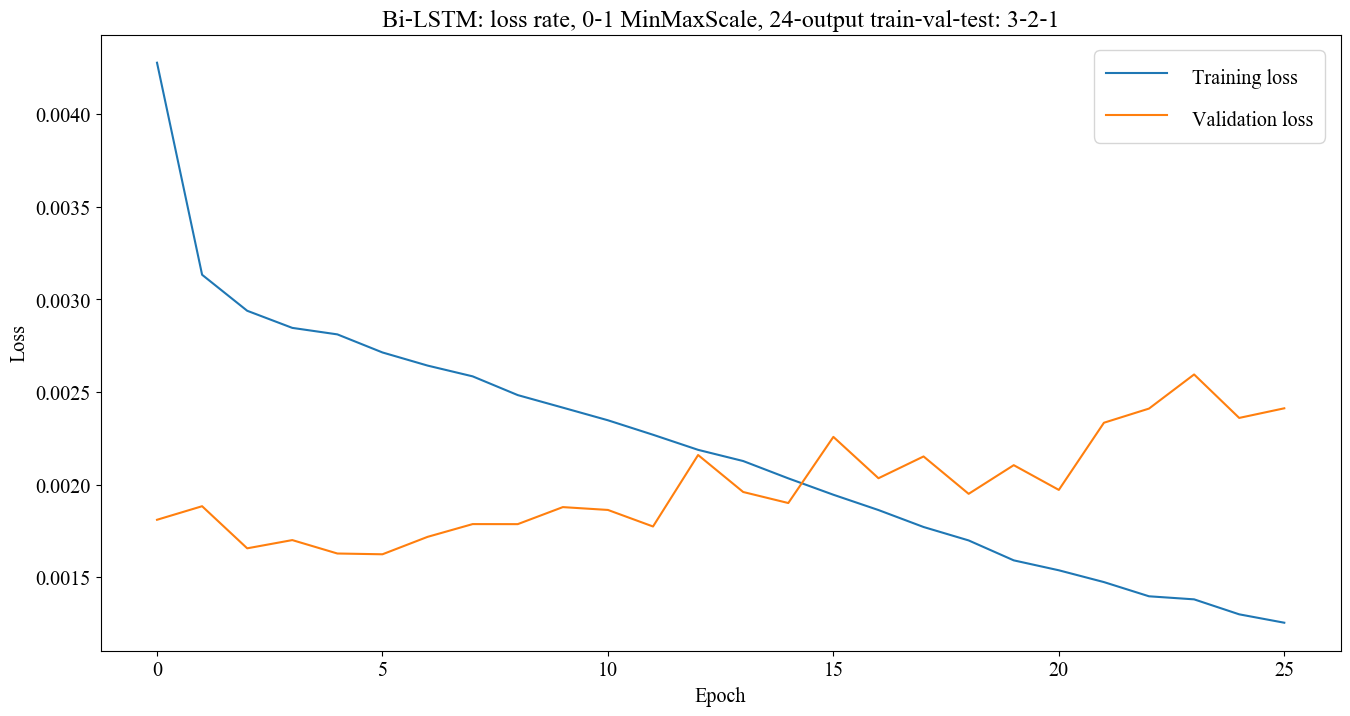

In [24]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM: loss rate, 0-1 MinMaxScale, 24-output train-val-test: 3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# #%%
# from keras.models import load_model

# model = load_model('checkpoint/01-bilstm-24-3-2-1.h5')

# #%%
# pred = model.predict(x_test)

# #%%
# if dataset.shape[1] > 1:
#     pred = np.repeat(pred, dataset.shape[1], axis=-1)

# #%%
# y_pred = scaler.inverse_transform(pred)[:,0]

# #%%
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

# #%%
# from sklearn.metrics import mean_squared_error

# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f'RMSE of Bi-LSTM = {rmse}')            

# #%%
# # rmse = np.sqrt(np.mean(np.square((y_test - y_pred))))
# # print(rmse)

# #%%
# rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
# print(f'RMSPE of Bi-LSTM = {rmspe}')


# #%%
# df_compare = pd.DataFrame({'Actual EC':df['ec_corrected'][train_set_len + valid_set_len:]})
# df_compare['Predicted EC'] = y_pred

# #%%
# plt.figure(figsize=(16,8))
# plt.title('Displays Actual EC vs. Predicted EC.')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.plot(df_compare['Actual EC'], label='Actual')
# plt.plot(df_compare['Predicted EC'], label='Predicted')
# plt.legend()
# plt.show()

# #%%
# plt.figure(figsize=(16,8))
# plt.title('Displays All Actual EC vs. Predicted EC.')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.plot(df['ec_new_.5'], label='All Actual EC')
# plt.plot(df_compare['Predicted EC'], label='Predicted')
# plt.legend()
# plt.show()

In [25]:
from keras.models import load_model

model = load_model('checkpoint/01-bilstm-24-3-2-1.h5')

In [26]:
pred = model.predict(x_test)

274/274 [==============================] - 19s 64ms/step


In [27]:
rpred = None

In [28]:
for i in range(pred.shape[1]):
    tpred = pred[:,i]
    tpred = np.reshape(tpred, (tpred.shape[0], 1))
    tpred = np.repeat(tpred, dataset.shape[1], axis=-1)
    tpred = scaler.inverse_transform(tpred)[:,0]
    tpred = np.reshape(tpred, (tpred.shape[0], 1))
    if rpred is None:
        rpred = tpred
    else:
        rpred = np.append(rpred, tpred, axis=1)

In [29]:
y_pred = rpred[:,0]
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [30]:
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

In [31]:
y_real = y_test[:,0]
y_real = np.reshape(y_real, (y_real.shape[0], 1))

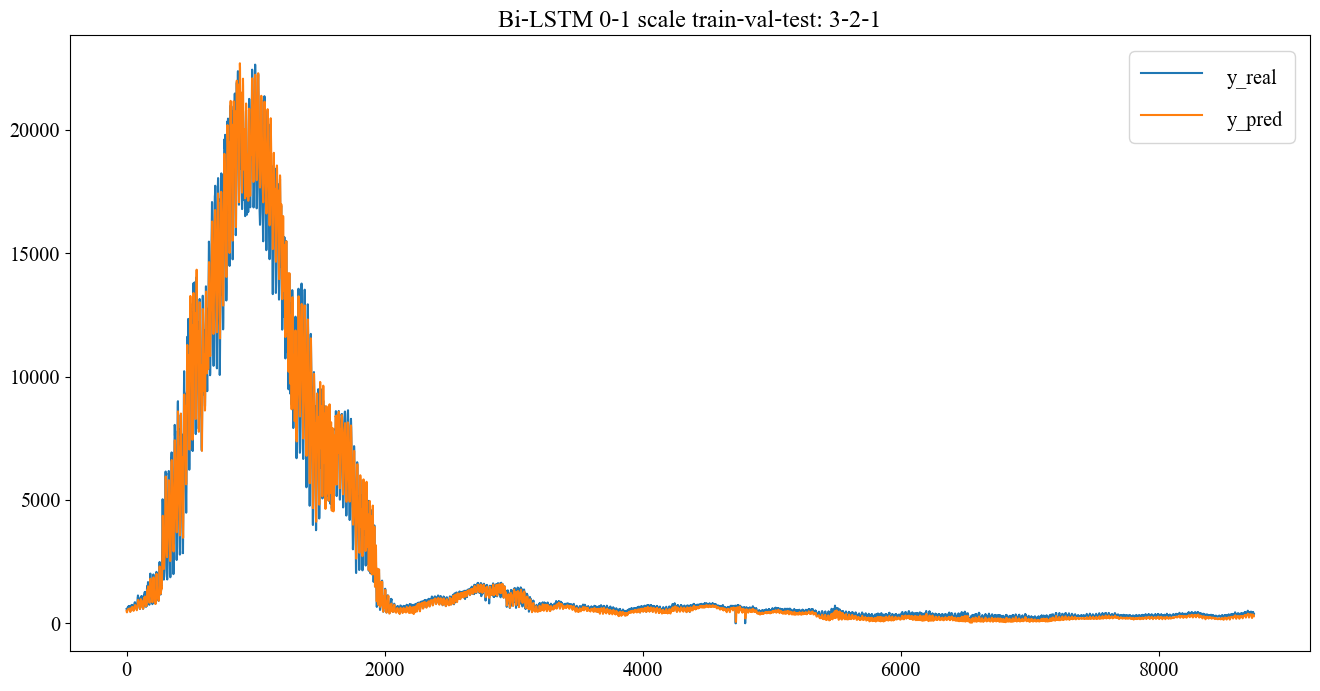

In [32]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM 0-1 scale train-val-test: 3-2-1')
plt.plot(y_real, label='y_real')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, rpred, squared=False)
print("RMSE of Bi-LSTM =",rmse)

RMSE of Bi-LSTM = 503.2583310423808


In [34]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE
mape = mean_absolute_percentage_error(y_test, rpred)
print(f'MAPE of Bi-LSTM = {mape}')

MAPE of Bi-LSTM = 0.7242313704443332
